## Biweekly Report 3

### Claire Lu

I explore the Adam optimization algorithm, one of the most widely used optimizers in deep learning. First, we implement a naive version of Adam to understand how it works. Then, apply the Adam implementation to train a Convolutional Neural Network (CNN) on the CIFAR-10 dataset and compare its performance against PyTorch’s built-in Adam. Adam combines momentum with adaptive learning rates, using past gradient information to accelerate convergence while adjusting the step size for each parameter.

parameters from: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

original paper and pseudocode: https://arxiv.org/pdf/1412.6980


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Explanation
Optimization in deep learning revolves around minimizing a loss function through iterative updates to model parameters. The simplest form of this process, Stochastic Gradient Descent (SGD), updates parameters by moving them in the direction opposite to the gradient of the loss. However, plain SGD can be inefficient when dealing with noisy gradients or complex data, as it uses a fixed learning rate and lacks adaptivity. With any model, our goal is to minimize our loss in order to improve the accuracy of our models predictions. Thus optimization of the loss function is crucial. We do this through gradient descent:

#### Gradient Descent

Training a neural network involves minimizing a loss function by adjusting the model’s parameters, defined by:

$
\theta_{t+1} = \theta_t - \alpha \nabla_\theta L_t
$

- $\alpha$ = learning rate
- $ \nabla_\theta L_t$ is the gradient of the loss with respect to the parameters.

The learning rate in this case is something fixed since it's a hyperparameter. If alpha is too small it might take more time than needed.

#### Adding Momentum
To improve convergence, momentum is introduced, which takes past gradients to maintain consistent progress in directions of persistent reduction in loss. Covnergence is improved and training is sped up, with vectors remembering the previous gradients.

Defined by velocity: $ m_t $:

$
m_t = \beta_1 m_{t-1} + (1 - \beta_1)\nabla_\theta L_t
$

Here, $ \beta_1 $ (i'll leave at 0.9) controls how much of the previous velocity we keep.  
The parameter becomes:

$
\theta_{t+1} = \theta_t - \alpha m_t
$

Thus we can add past gradients to the current gradient before each update. The farther back the gradiant the less update it has because each iterative multiplication reduces contribution.

#### RMSProp

After momentum, we should consider the gradient magnitudes of different parameters. RMSProp (Root Mean Squared Propagation) makes sure we consider the magnitudes of our gradients equally during descent. This should make the optimzer converge quicker and reduce inefficent learning. It uses adaptive learning rates by scaling updates inversely with the square root of recent gradient magnitudes.
RMSProp is defined as:

$
v_t = \beta_2 v_{t-1} + (1 - \beta_2)(\nabla_\theta L_t)^2
$

By dividing the learning rate by $ \sqrt{v_t} + \epsilon $, we scale down updates for parameters with consistently large gradients and scale up for those with smaller ones:

$
\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{v_t} + \epsilon} \nabla_\theta L_t
$

Normalization balances how each parameter learns, preventing weights with larger previous gradients from being updated too much. Thus the weights are balanced during optimization.

#### Adam

Adam essentially combines RMSProp and momentum:

$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$

$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$

There is inital bias when training begins. Both momentum and the velocity are biased towards zero, so we account for it via:

$
\hat{m_t} = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v_t} = \frac{v_t}{1 - \beta_2^t}
$


$
\theta_{t+1} = \theta_t - \alpha \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon}
$

hyperparameters :
$
\alpha = 0.001, \quad \beta_1 = 0.9, \quad \beta_2 = 0.99,
$

Thus Adam derives from Momentum stablity as well as the adaptivity of RMSprop, with correction for bias in early stage training.


### Implementation
Here we implement Adam as described. 
At initialization, all moment estimates are zero tensors matching their parameters. For each parameter, there are two tensors are m for the first moment (mean of gradients) and v for the second moment (variance of gradients). It performs gradient retrieval at each pass, and updates to 'smooth' out the gradient history. At every step, these moments are updated using exponential moving averages determined by hyperparameters $\alpha = 0.001, \quad \beta_1 = 0.9, \quad \beta_2 = 0.99,$, which determine the weights of past information. The velocity of the gradient magnitudes of parameters is also accounted for. Bias correction is applied because of momentum and velocity's bias towards 0 in early steps.

In [2]:
class NaiveAdam:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.m = [torch.zeros_like(p.data) for p in self.params]
        self.v = [torch.zeros_like(p.data) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None: 
                continue
            g = p.grad.data
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * g.pow(2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            p.data -= self.lr * m_hat / (v_hat.sqrt() + self.eps)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


We set up a CNN model using CIFAR-10, as explained in my previous report. It goes through normalization of pixel values and sets up batching for training and testing. The CNN class is just two convolutional layers followed by relu and pooling. It's then followed by two fully connected layers for classification output.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


The function trains a given model using an optimizer (depending on what is specified) on the CIFAR-10 dataset for a set number of epochs. During training, it computes the loss using cross-entropy, and updates the model parameters with backpropagation. After each epoch, it evaluates the model on the test set to test accuracy for evaluation and analysis.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, optimizer, trainloader, testloader, epochs=5, print_last=5):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    history = {'train_loss': [], 'test_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        
        #evaluationn
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        
        history['train_loss'].append(avg_loss)
        history['test_acc'].append(acc)
        if epoch >= epochs - print_last:
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Acc: {acc:.2f}%")
    return history


#### Comparing implemented Adam vs PyTorch Adam

In [5]:
#naive adam
model_naive = SimpleCNN().to(device)
optimizer_naive = NaiveAdam(model_naive.parameters(), lr=1e-3)
history_naive = train_model(model_naive, optimizer_naive, trainloader, testloader, epochs=20)

#pytorch's adam
model_torch = SimpleCNN().to(device)
optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=1e-3)
history_torch = train_model(model_torch, optimizer_torch, trainloader, testloader, epochs=20)


Epoch [16/20] - Loss: 0.0509 - Acc: 72.29%
Epoch [17/20] - Loss: 0.0501 - Acc: 72.17%
Epoch [18/20] - Loss: 0.0478 - Acc: 70.96%
Epoch [19/20] - Loss: 0.0471 - Acc: 72.27%
Epoch [20/20] - Loss: 0.0372 - Acc: 71.67%
Epoch [16/20] - Loss: 0.0594 - Acc: 70.37%
Epoch [17/20] - Loss: 0.0550 - Acc: 71.00%
Epoch [18/20] - Loss: 0.0593 - Acc: 70.21%
Epoch [19/20] - Loss: 0.0384 - Acc: 70.25%
Epoch [20/20] - Loss: 0.0397 - Acc: 70.35%


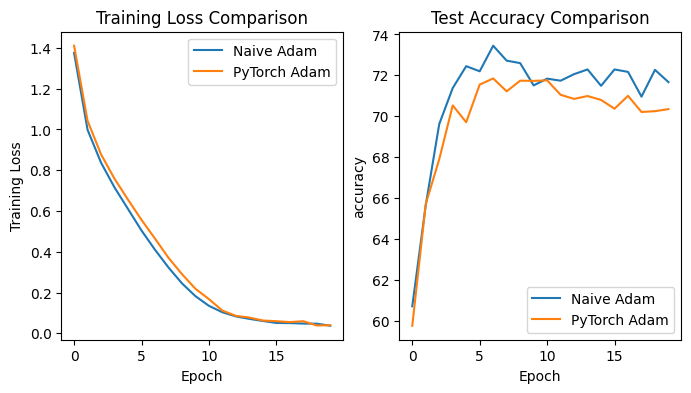

In [6]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history_naive['train_loss'], label='Naive Adam')
plt.plot(history_torch['train_loss'], label='PyTorch Adam')
plt.xlabel('Epoch'); 
plt.ylabel('Training Loss')
plt.legend(); plt.title('Training Loss Comparison')

plt.subplot(1,2,2)
plt.plot(history_naive['test_acc'], label='Naive Adam')
plt.plot(history_torch['test_acc'], label='PyTorch Adam')
plt.xlabel('Epoch'); 
plt.ylabel('accuracy')
plt.legend(); plt.title('Test Accuracy Comparison')
plt.show()

The two optimizers show similar convergence behavior, showing relative accuracy of the Adam implementation. The convergence is most likely more stable compared to just using SGD or SGD with momentum alone. Minor differences may arise from numerical error to internal parameters. Overall, Adam optimizer effectively stablilizes training and and accelerates convergence in CNNs. The implementation successfully stablizies the training by controlling the parameter and adaptively adjusting learning rates. In future work, I could do comparative analysis of Adam with SGD, SGD with momentum, RMSProp by itself, etc to see impact of each derivation on convergance. Additionally, I could explore the effects of different hyperparameters and how they would affect convergence as well as test the optimizer on different, larger datasets.
